In [1]:
import requests
from bs4 import BeautifulSoup
import json

### Делаем красиво

In [20]:
def extract_json_from_page(url):
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        script_tags = soup.find_all(
            name='script', attrs={'type': 'application/ld+json'})

        script_tag = script_tags[0]
        script_content = script_tag.string

        # print(script_content)

        json_data = json.loads(script_content, strict=False)
        return json_data
    else:
        print(response.status_code)

    return None

### Тестируем

In [6]:
url = 'https://www.banki.ru/services/responses/bank/tcs/'
json_data = extract_json_from_page(url)

# Выводим JSON-данные, если они были найдены
if json_data:
    data = json.dumps(json_data, indent=4, ensure_ascii=False)
    print('Данные получены и сохранены в output.json')
    with open('output.json', 'w', encoding='utf-8') as f:
        json.dump(json_data, f, indent=4, ensure_ascii=False)
else:
    print("JSON-данные не найдены на указанной странице.")

Данные получены и сохранены в output.json


### Пишем нормальный код

In [50]:
def parse_responses(url, num_of_pages, output_file):
    first_page_parsed = False
    with open(output_file, 'w', encoding='utf-8') as f:
        for current_page in range(1, num_of_pages+1):
            json_data = extract_json_from_page(f'{url}/?page={current_page}')
            if json_data:
                # Если это первая страница, сохраняем поля, кроме отзывов
                if not first_page_parsed:
                    json.dump({k: v for k, v in json_data.items() if k != 'review'}, f, ensure_ascii=False, indent=4)
                    f.write('\n')
                    f.write('\t"review": [\n')
                    first_page_parsed = True
                # Добавляем отзывы в общий блок
                for review in json_data['review']:
                    json.dump(review, f, ensure_ascii=False, indent=4)
                    f.write(',\n')
        # Закрываем блок отзывов
        # f.write(']\n}\n')


In [77]:
url = 'https://www.banki.ru/services/responses/bank/tcs'
num_of_pages = 2  # Количество страниц для парсинга
output_file = 'output.json'  # Имя файла для сохранения данных

parse_responses(url, num_of_pages, output_file)


### Чистим файлик

In [79]:
def clean_output_file(output_file):
    with open(output_file, 'r+', encoding='utf-8') as f:
        data = f.readlines()
        # Убираем фигурную скобку в конце первого блока
        data[10] = data[10].rstrip('\n') + ',\n'
        data[11] = data[11].rstrip('}\n')
        # Чиним конец
        data[-1] = data[-1][:-2] + '\n'
        # Перезаписываем файл
        f.seek(0)
        f.writelines(data)
        # Опять чиним конец
        f.write(']\n}\n')


In [80]:
clean_output_file(output_file)

### Итого:

In [16]:
import requests
from bs4 import BeautifulSoup
import json


def extract_json_from_page(url):
    response = requests.get(url)

    if response.status_code == 200:
        try:
            soup = BeautifulSoup(response.text, 'html.parser')

            script_tags = soup.find_all(
                name='script', attrs={'type': 'application/ld+json'})

            script_tag = script_tags[0]
            script_content = script_tag.string

            # print(script_content)

            json_data = json.loads(script_content, strict=False)
            return json_data
        except:
            print('JSON error: pass')
            return None
    else:
        print(response.status_code)

    return None


def clean_output_file(output_file):
    with open(output_file, 'r+', encoding='utf-8') as f:
        data = f.readlines()
        # Убираем фигурную скобку в конце первого блока
        data[10] = data[10].rstrip('\n') + ',\n'
        data[11] = data[11].rstrip('}\n')
        # Чиним конец
        data[-1] = data[-1][:-2] + '\n'
        # Перезаписываем файл
        f.seek(0)
        f.writelines(data)
        # Опять чиним конец
        f.write(']\n}\n')


def parse_responses(url, num_of_pages, output_file):
    first_page_parsed = False
    with open(output_file, 'w', encoding='utf-8') as f:
        for current_page in range(1, num_of_pages+1):
            json_data = extract_json_from_page(f'{url}/?page={current_page}')
            if json_data:
                # Если это первая страница, сохраняем поля, кроме отзывов
                if not first_page_parsed:
                    json.dump({k: v for k, v in json_data.items() if k !=
                              'review'}, f, ensure_ascii=False, indent=4)
                    f.write('\n')
                    f.write('\t"review": [\n')
                    first_page_parsed = True
                # Добавляем отзывы в общий блок
                for review in json_data['review']:
                    json.dump(review, f, ensure_ascii=False, indent=4)
                    f.write(',\n')
            
            print(f'Page {current_page} processed!')

    # Чистим получившиеся данные
    clean_output_file(output_file)


url = 'https://www.banki.ru/services/responses/bank/tcs'
num_of_pages = 2  # Количество страниц для парсинга; Интересный факт - максимальное кол-во страниц: 2078, первый отзыв оставлен 04.02.2008 в 20:04
output_file = 'lite-output.json'  # Имя файла для сохранения данных

parse_responses(url, num_of_pages, output_file)

Page 1 processed!
Page 2 processed!


### Наваливаем пандаса

In [17]:
import pandas as pd

In [3]:
def read_reviews_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        reviews = []
        for review in data['review']:
            reviews.append({
                'author': review['author'],
                'datePublished': pd.to_datetime(review['datePublished']),
                'description': review['description'],
                'name': review['name'],
                'ratingValue': review['reviewRating']['ratingValue']
            })
        return pd.DataFrame(reviews)
    

In [4]:
file_path = 'output.json'
reviews_df = read_reviews_from_file(file_path)

In [5]:
reviews_df

,author,datePublished,description,name,ratingValue
0,user-871213969739,2024-03-27 19:04:09,&lt;p&gt;Всех приветствую товарищи! Хочу подел...,Как мне сняли ограничение по 115ФЗ от Тинькофф...,5
1,Milleroff,2024-03-27 17:23:38,&lt;p&gt;Я являюсь клиентом Тинькофф Премиум и...,Банк с человеческим лицом,5
2,user-895516823510,2024-03-26 07:56:29,&lt;p&gt;Хочу выразить благодарность сотрудник...,Благодарность за качество обслуживания,5
3,user-918817541893,2024-03-25 22:27:47,"&lt;p&gt;Я написала в чат 25.03.2024 в 21:51, ...",Отзыв о работе операторов Тинькофф,5
4,user-949812016540,2024-03-25 21:10:33,&lt;p&gt;Доброго времени суток. Привела в банк...,Немного неприятностей от приятного банка,2
...,...,...,...,...,...
12295,user-446515069294,2023-09-06 06:22:26,"&lt;p&gt;Ээээй, всем здаровушки, думаю многие ...",Елена затащила эту делюгу,4
12296,user-855015069173,2023-09-06 06:10:09,&lt;p&gt;Хотел бы оставить отзыв о работе чата...,Отличный банк,5
12297,user-581815069197,2023-09-06 06:01:43,"&lt;p&gt;Спасибо огромное Сотниковой Юлии, оче...",Помощь на начальном этапе,5
12298,user-494115069188,2023-09-06 05:57:31,&lt;p&gt;Неосознанно столкнулась с мошенниками...,Защита от мошенников,5


### Строим не очень крутые графики

In [6]:
import matplotlib.pyplot as plt

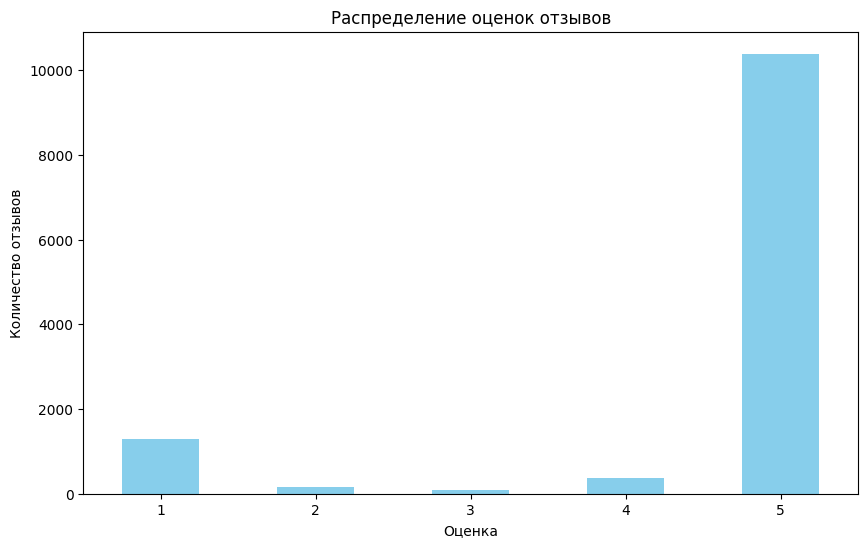

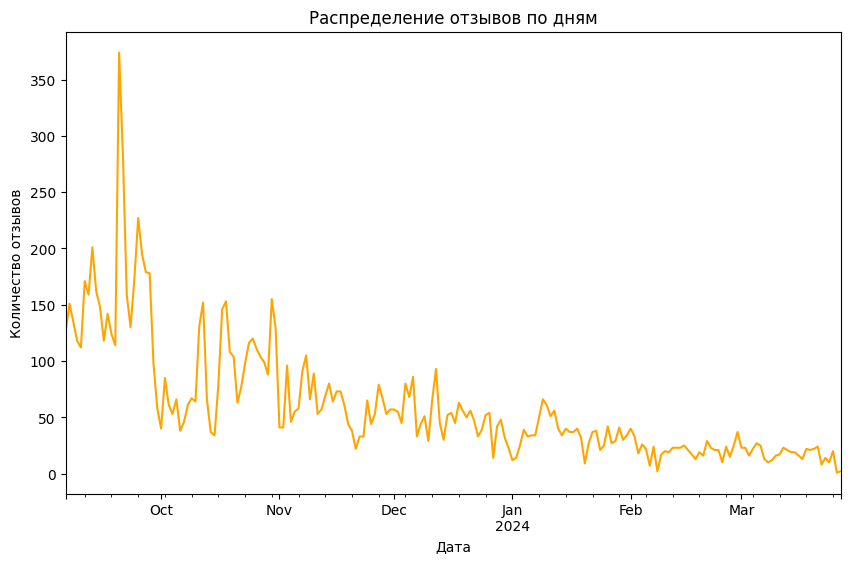

In [7]:
# Отзывы по оценкам
plt.figure(figsize=(10, 6))
reviews_df['ratingValue'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение оценок отзывов')
plt.xlabel('Оценка')
plt.ylabel('Количество отзывов')
plt.xticks(rotation=0)
plt.show()

# Распределение отзывов по дням
plt.figure(figsize=(10, 6))
reviews_df.set_index('datePublished').resample('D').size().plot(color='orange')
plt.title('Распределение отзывов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество отзывов')
plt.show()



### Анализируем

In [39]:
file_path = 'lite-output.json'
lite_reviews_df = read_reviews_from_file(file_path)

In [19]:
lite_reviews_df

,author,datePublished,description,name,ratingValue
0,user-871213969739,2024-03-27 19:04:09,&lt;p&gt;Всех приветствую товарищи! Хочу подел...,Как мне сняли ограничение по 115ФЗ от Тинькофф...,5
1,Milleroff,2024-03-27 17:23:38,&lt;p&gt;Я являюсь клиентом Тинькофф Премиум и...,Банк с человеческим лицом,5
2,user-733917540998,2024-03-26 13:05:06,&lt;p&gt;Здравствуйте! В январе банк открыл ка...,Нарушение прав,1
3,user-20638323398,2024-03-26 11:37:04,&lt;p&gt;Являюсо клиентом Тинькофф банка с 201...,"Тинькофф, как Вы это делаете?!",5
4,user-909517545802,2024-03-26 11:32:52,&lt;p&gt;Открытие счета происходит моментально...,Пощади моя господина!,1
5,user-895516823510,2024-03-26 07:56:29,&lt;p&gt;Хочу выразить благодарность сотрудник...,Благодарность за качество обслуживания,5
6,user-918817541893,2024-03-25 22:27:47,"&lt;p&gt;Я написала в чат 25.03.2024 в 21:51, ...",Отзыв о работе операторов Тинькофф,5
7,user-949812016540,2024-03-25 21:10:33,&lt;p&gt;Доброго времени суток. Привела в банк...,Немного неприятностей от приятного банка,2
8,user-253616412975,2024-03-25 20:29:42,&lt;p&gt;Хочу поблагодарить всю команду Тинько...,Закрытие счета,5
9,user-667517540508,2024-03-25 19:56:17,"&lt;p&gt;При оформлении автокредита, Тиньков д...",Отказ в помощи,1


In [38]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import torch
import numpy as np

In [40]:
# От этого способа анализа мы отказались!

# Загрузка модели DistilBERT
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Функция для предварительной обработки текста и классификации с помощью модели DistilBERT
def classify_text(text):
    # Предварительная обработка текста
    text = text.lower()  # Приведем текст к нижнему регистру
    text = text.replace('\n', ' ')  # Уберем переносы строк
    text = text.strip()  # Уберем пробельные символы в начале и в конце текста
    # Преобразуем текст в последовательность токенов
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()
    return probabilities[:, 1]  # Возвращаем вероятность отнесения к классу "положительный"

# Функция для анализа отзывов и добавления данных об окраске в датафрейм
def analyze_reviews(lite_reviews_df):
    sentiments = []
    for index, row in lite_reviews_df.iterrows():
        text = row['description']
        sentiment = classify_text(text)
        sentiments.append(sentiment)
    lite_reviews_df['sentiment'] = sentiments
    lite_reviews_df['sentiment_label'] = np.where(lite_reviews_df['sentiment'] >= 0.5, 'positive', 'negative')

# Применяем функцию для анализа отзывов и добавления данных об окраске в датафрейм
analyze_reviews(lite_reviews_df)


c:\Python311\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nout\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and 

Возможно, у вас нет датафреймов lite_reviews и very_lite_reviews. Их можно найти на гитхабе

In [46]:
lite_reviews_df[lite_reviews_df['sentiment'] < 0.5]

,author,datePublished,description,name,ratingValue,sentiment,sentiment_label
0,user-871213969739,2024-03-27 19:04:09,&lt;p&gt;Всех приветствую товарищи! Хочу подел...,Как мне сняли ограничение по 115ФЗ от Тинькофф...,5,[0.4979949],negative
1,Milleroff,2024-03-27 17:23:38,&lt;p&gt;Я являюсь клиентом Тинькофф Премиум и...,Банк с человеческим лицом,5,[0.49772793],negative
2,user-733917540998,2024-03-26 13:05:06,&lt;p&gt;Здравствуйте! В январе банк открыл ка...,Нарушение прав,1,[0.49206054],negative
3,user-20638323398,2024-03-26 11:37:04,&lt;p&gt;Являюсо клиентом Тинькофф банка с 201...,"Тинькофф, как Вы это делаете?!",5,[0.49924144],negative
4,user-909517545802,2024-03-26 11:32:52,&lt;p&gt;Открытие счета происходит моментально...,Пощади моя господина!,1,[0.49515942],negative
5,user-895516823510,2024-03-26 07:56:29,&lt;p&gt;Хочу выразить благодарность сотрудник...,Благодарность за качество обслуживания,5,[0.49679118],negative
6,user-918817541893,2024-03-25 22:27:47,"&lt;p&gt;Я написала в чат 25.03.2024 в 21:51, ...",Отзыв о работе операторов Тинькофф,5,[0.4933084],negative
7,user-949812016540,2024-03-25 21:10:33,&lt;p&gt;Доброго времени суток. Привела в банк...,Немного неприятностей от приятного банка,2,[0.48933557],negative
8,user-253616412975,2024-03-25 20:29:42,&lt;p&gt;Хочу поблагодарить всю команду Тинько...,Закрытие счета,5,[0.4977042],negative
9,user-667517540508,2024-03-25 19:56:17,"&lt;p&gt;При оформлении автокредита, Тиньков д...",Отказ в помощи,1,[0.49898502],negative


In [68]:
lite_reviews_df

,author,datePublished,description,name,ratingValue,sentiment,sentiment_label
0,user-871213969739,2024-03-27 19:04:09,&lt;p&gt;Всех приветствую товарищи! Хочу подел...,Как мне сняли ограничение по 115ФЗ от Тинькофф...,5,[0.4979949],negative
1,Milleroff,2024-03-27 17:23:38,&lt;p&gt;Я являюсь клиентом Тинькофф Премиум и...,Банк с человеческим лицом,5,[0.49772793],negative
2,user-733917540998,2024-03-26 13:05:06,&lt;p&gt;Здравствуйте! В январе банк открыл ка...,Нарушение прав,1,[0.49206054],negative
3,user-20638323398,2024-03-26 11:37:04,&lt;p&gt;Являюсо клиентом Тинькофф банка с 201...,"Тинькофф, как Вы это делаете?!",5,[0.49924144],negative
4,user-909517545802,2024-03-26 11:32:52,&lt;p&gt;Открытие счета происходит моментально...,Пощади моя господина!,1,[0.49515942],negative
5,user-895516823510,2024-03-26 07:56:29,&lt;p&gt;Хочу выразить благодарность сотрудник...,Благодарность за качество обслуживания,5,[0.49679118],negative
6,user-918817541893,2024-03-25 22:27:47,"&lt;p&gt;Я написала в чат 25.03.2024 в 21:51, ...",Отзыв о работе операторов Тинькофф,5,[0.4933084],negative
7,user-949812016540,2024-03-25 21:10:33,&lt;p&gt;Доброго времени суток. Привела в банк...,Немного неприятностей от приятного банка,2,[0.48933557],negative
8,user-253616412975,2024-03-25 20:29:42,&lt;p&gt;Хочу поблагодарить всю команду Тинько...,Закрытие счета,5,[0.4977042],negative
9,user-667517540508,2024-03-25 19:56:17,"&lt;p&gt;При оформлении автокредита, Тиньков д...",Отказ в помощи,1,[0.49898502],negative


In [69]:
url = 'https://www.banki.ru/services/responses/bank/tcs'
num_of_pages = 1  # Количество страниц для парсинга; Интересный факт - максимальное кол-во страниц: 2078, первый отзыв оставлен 04.02.2008 в 20:04
output_file = 'very-lite-output.json'  # Имя файла для сохранения данных

parse_responses(url, num_of_pages, output_file)
very_lite_reviews_df = read_reviews_from_file(output_file)

Page 1 processed!


In [70]:
very_lite_reviews_df

,author,datePublished,description,name,ratingValue
0,user-871213969739,2024-03-27 19:04:09,&lt;p&gt;Всех приветствую товарищи! Хочу подел...,Как мне сняли ограничение по 115ФЗ от Тинькофф...,5
1,Milleroff,2024-03-27 17:23:38,&lt;p&gt;Я являюсь клиентом Тинькофф Премиум и...,Банк с человеческим лицом,5
2,user-733917540998,2024-03-26 13:05:06,&lt;p&gt;Здравствуйте! В январе банк открыл ка...,Нарушение прав,1
3,user-20638323398,2024-03-26 11:37:04,&lt;p&gt;Являюсо клиентом Тинькофф банка с 201...,"Тинькофф, как Вы это делаете?!",5
4,user-909517545802,2024-03-26 11:32:52,&lt;p&gt;Открытие счета происходит моментально...,Пощади моя господина!,1
5,user-895516823510,2024-03-26 07:56:29,&lt;p&gt;Хочу выразить благодарность сотрудник...,Благодарность за качество обслуживания,5
6,user-918817541893,2024-03-25 22:27:47,"&lt;p&gt;Я написала в чат 25.03.2024 в 21:51, ...",Отзыв о работе операторов Тинькофф,5
7,user-949812016540,2024-03-25 21:10:33,&lt;p&gt;Доброго времени суток. Привела в банк...,Немного неприятностей от приятного банка,2
8,user-253616412975,2024-03-25 20:29:42,&lt;p&gt;Хочу поблагодарить всю команду Тинько...,Закрытие счета,5
9,user-667517540508,2024-03-25 19:56:17,"&lt;p&gt;При оформлении автокредита, Тиньков д...",Отказ в помощи,1


In [61]:
import time

In [ ]:
SECRET = ''
SECRET2 = ''

In [75]:
def analyze_reviews_with_gpt(reviews, dataframe):
    url = "https://llm.api.cloud.yandex.net/foundationModels/v1/completion"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Api-Key {SECRET}"
    }
    
    problems = []
    fields = []
    for idx, review in enumerate(reviews):
        prompt = {
            "modelUri": f"gpt://{SECRET2}/yandexgpt/latest",
            "completionOptions": {
                "stream": False,
                "temperature": 0.0,
                "maxTokens": 500
            },
            "messages": [
                {
                    "role": "system",
                    "text": "Ты - опытный аналитик. Тебе будет предоставлен отзыв о банке Тинькофф. Определи к каким разделам относится отзыв:\nСотрудники\nАкции\nОперации над денежными средствами\nПродукты компании\nУслуги\nДействия со Счетом\nЛичный кабинет\nДругое\n\nВыведи список разделов в таком формате:\n'Раздел 1\nРаздел 2\nРаздел n'\nЕСЛИ РАЗДЕЛ НЕ ВСТРЕЧАЕТСЯ В ОТЗЫВЕ, НЕ УКАЗЫВАЙ ЕГО"
                },
                {
                    "role": "user",
                    "text": review
                }
            ]
        }
        
        response = requests.post(url, headers=headers, json=prompt)
        data = response.json()
        print(data)
        analyzed_text = data['result']['alternatives'][0]['message']['text']
        
        fields.append(analyzed_text.split('\n'))
        print(analyzed_text.split('\n'))

        time.sleep(1)
        
    dataframe['field'] = fields
    return problems

In [77]:
reviews = very_lite_reviews_df['description'].tolist()
found_problems = analyze_reviews_with_gpt(reviews, very_lite_reviews_df)

if found_problems:
    print("Найдены следующие проблемы:")
    for problem in found_problems:
        print(problem)
else:
    print("Проблемы не найдены.")

{'result': {'alternatives': [{'message': {'role': 'assistant', 'text': 'Сотрудники.\nДругое.'}, 'status': 'ALTERNATIVE_STATUS_FINAL'}], 'usage': {'inputTextTokens': '594', 'completionTokens': '6', 'totalTokens': '600'}, 'modelVersion': '07.03.2024'}}
['Сотрудники.', 'Другое.']
{'result': {'alternatives': [{'message': {'role': 'assistant', 'text': 'Сотрудники.\nПерсональный менеджер Денис Г-в.\n\nОперации над денежными средствами.\nВозврат денежных средств.\nЗачисление денежных средств на счёт.\n\nДругое.\nБлагодарность банку.'}, 'status': 'ALTERNATIVE_STATUS_FINAL'}], 'usage': {'inputTextTokens': '325', 'completionTokens': '41', 'totalTokens': '366'}, 'modelVersion': '07.03.2024'}}
['Сотрудники.', 'Персональный менеджер Денис Г-в.', '', 'Операции над денежными средствами.', 'Возврат денежных средств.', 'Зачисление денежных средств на счёт.', '', 'Другое.', 'Благодарность банку.']
{'result': {'alternatives': [{'message': {'role': 'assistant', 'text': 'Сотрудники\nДействия со Счётом\nЛич

In [90]:
very_lite_reviews_df

,author,datePublished,description,name,ratingValue,field
0,user-871213969739,2024-03-27 19:04:09,&lt;p&gt;Всех приветствую товарищи! Хочу подел...,Как мне сняли ограничение по 115ФЗ от Тинькофф...,5,"[Сотрудники., Другое.]"
1,Milleroff,2024-03-27 17:23:38,&lt;p&gt;Я являюсь клиентом Тинькофф Премиум и...,Банк с человеческим лицом,5,"[Сотрудники., Персональный менеджер Денис Г-в...."
2,user-733917540998,2024-03-26 13:05:06,&lt;p&gt;Здравствуйте! В январе банк открыл ка...,Нарушение прав,1,"[Сотрудники, Действия со Счётом, Личный кабинет]"
3,user-20638323398,2024-03-26 11:37:04,&lt;p&gt;Являюсо клиентом Тинькофф банка с 201...,"Тинькофф, как Вы это делаете?!",5,"[Сотрудники., Действия со Счётом.]"
4,user-909517545802,2024-03-26 11:32:52,&lt;p&gt;Открытие счета происходит моментально...,Пощади моя господина!,1,"[* Открытие и оформление счёта., * Операции на..."
5,user-895516823510,2024-03-26 07:56:29,&lt;p&gt;Хочу выразить благодарность сотрудник...,Благодарность за качество обслуживания,5,[Сотрудники]
6,user-918817541893,2024-03-25 22:27:47,"&lt;p&gt;Я написала в чат 25.03.2024 в 21:51, ...",Отзыв о работе операторов Тинькофф,5,[Сотрудники.]
7,user-949812016540,2024-03-25 21:10:33,&lt;p&gt;Доброго времени суток. Привела в банк...,Немного неприятностей от приятного банка,2,"[* Проблемы с выплатами по акции., * Регистрац..."
8,user-253616412975,2024-03-25 20:29:42,&lt;p&gt;Хочу поблагодарить всю команду Тинько...,Закрытие счета,5,[Сотрудники]
9,user-667517540508,2024-03-25 19:56:17,"&lt;p&gt;При оформлении автокредита, Тиньков д...",Отказ в помощи,1,"[* Продукты компании (автокредит)., * Операции..."


In [109]:
very_lite_reviews_df.to_csv('database.csv')


In [123]:
very_lite_reviews_df.to_json('database.json', force_ascii=False)


### Выделенные проблемы

Раньше мы использовали другой алгоритм, он выделял проблемы

In [74]:
found_problems

['Отзыв №2:\nПроблема 1: Неполучение возврата денежных средств за отменённый заказ.\nПроблема 2: Нет.',
 'Отзыв №6:\nПроблема 1:    \nНет.\n\nПроблема 2:\n\n1.\tНачисление налогов.\n2.\tПорядок начисления и уплаты.\n3.\tПредоставление ежегодной декларации.',
 'Отзыв №7:\nПроблема 1: Отсутствие наименования продукта партнёра в чеке.\nПроблема 2: Нет.',
 'Отзыв №8:\nПроблема 1: На странице акции указано выполнение ЦД, но выплата не начислена.\nПроблема 2: Лиду была добавлена карта с расчётным счётом, которая изначально не требовалась.\nПроблема 3: Порезан размер выплаты после добавления карты.\nПроблема 4: Банк не выплачивает деньги быстро и без задержек в финансовых партнёрских программах.',
 'Отзыв №9:\nПроблема 1:  \nНет.',
 'Отзыв №11:\n1. Проблема 1: Навязывание кредитных карт и мобильной связи.\n\n2. Проблема отсутствует.',
 'Отзыв №15:\n1. Проблема №1: Дважды вскрытые конверты с картами.\n\n2. Проблема №2: Блокировка приложения вместо блокировки карты.\n\n3. Проблема №3: Потеря до

### Чистим

In [92]:
import re

In [93]:
def clean_field(field):
    if isinstance(field, list):
        cleaned_field = []
        for item in field:
            cleaned_item = re.sub(r'\W+', '', item.lower().strip())  # Удаляем все не-буквенно-цифровые символы
            if cleaned_item:  # Проверяем, не пустая ли строка после очистки
                cleaned_field.append(cleaned_item)
        return cleaned_field
    else:
        return []

# Применяем функцию clean_field к столбцу field
very_lite_reviews_df['field'] = very_lite_reviews_df['field'].apply(clean_field)

In [94]:
very_lite_reviews_df

,author,datePublished,description,name,ratingValue,field
0,user-871213969739,2024-03-27 19:04:09,&lt;p&gt;Всех приветствую товарищи! Хочу подел...,Как мне сняли ограничение по 115ФЗ от Тинькофф...,5,"[сотрудники, другое]"
1,Milleroff,2024-03-27 17:23:38,&lt;p&gt;Я являюсь клиентом Тинькофф Премиум и...,Банк с человеческим лицом,5,"[сотрудники, персональныйменеджерденисгв, опер..."
2,user-733917540998,2024-03-26 13:05:06,&lt;p&gt;Здравствуйте! В январе банк открыл ка...,Нарушение прав,1,"[сотрудники, действиясосчётом, личныйкабинет]"
3,user-20638323398,2024-03-26 11:37:04,&lt;p&gt;Являюсо клиентом Тинькофф банка с 201...,"Тинькофф, как Вы это делаете?!",5,"[сотрудники, действиясосчётом]"
4,user-909517545802,2024-03-26 11:32:52,&lt;p&gt;Открытие счета происходит моментально...,Пощади моя господина!,1,"[открытиеиоформлениесчёта, операциинадденежным..."
5,user-895516823510,2024-03-26 07:56:29,&lt;p&gt;Хочу выразить благодарность сотрудник...,Благодарность за качество обслуживания,5,[сотрудники]
6,user-918817541893,2024-03-25 22:27:47,"&lt;p&gt;Я написала в чат 25.03.2024 в 21:51, ...",Отзыв о работе операторов Тинькофф,5,[сотрудники]
7,user-949812016540,2024-03-25 21:10:33,&lt;p&gt;Доброго времени суток. Привела в банк...,Немного неприятностей от приятного банка,2,"[проблемысвыплатамипоакции, регистрацияип, отк..."
8,user-253616412975,2024-03-25 20:29:42,&lt;p&gt;Хочу поблагодарить всю команду Тинько...,Закрытие счета,5,[сотрудники]
9,user-667517540508,2024-03-25 19:56:17,"&lt;p&gt;При оформлении автокредита, Тиньков д...",Отказ в помощи,1,"[продуктыкомпанииавтокредит, операциинадденежн..."


### Фильтруем

In [95]:
def filter_reviews_by_category(dataframe, categories):
    filtered_reviews = dataframe[dataframe['field'].apply(lambda x: any(category.lower() in x for category in categories))]
    return filtered_reviews


In [104]:
# Пример использования функции для получения отзывов, принадлежащих категории "Сотрудники"
employee_reviews = filter_reviews_by_category(very_lite_reviews_df, ['сотрудники'])
print("Отзывы о сотрудниках:")
print(employee_reviews.head)

# Пример использования функции для получения отзывов, принадлежащих категориям "Сотрудники" и "Продукты компании"
employee_product_reviews = filter_reviews_by_category(very_lite_reviews_df, ['сотрудники', 'продуктыкомпании'])
print("\nОтзывы о сотрудниках и продуктах компании:")
print(employee_product_reviews.head)


Отзывы о сотрудниках:
<bound method NDFrame.head of                author       datePublished  \
0   user-871213969739 2024-03-27 19:04:09   
1           Milleroff 2024-03-27 17:23:38   
2   user-733917540998 2024-03-26 13:05:06   
3    user-20638323398 2024-03-26 11:37:04   
5   user-895516823510 2024-03-26 07:56:29   
6   user-918817541893 2024-03-25 22:27:47   
8   user-253616412975 2024-03-25 20:29:42   
10  user-823317540379 2024-03-25 19:46:05   
15  user-530717537684 2024-03-25 16:25:38   
17  user-667317537100 2024-03-25 16:01:04   
19  user-228817535647 2024-03-25 13:39:50   
21  user-319217105697 2024-03-25 10:38:32   
22  user-358217358629 2024-03-25 10:09:16   

                                          description  \
0   &lt;p&gt;Всех приветствую товарищи! Хочу подел...   
1   &lt;p&gt;Я являюсь клиентом Тинькофф Премиум и...   
2   &lt;p&gt;Здравствуйте! В январе банк открыл ка...   
3   &lt;p&gt;Являюсо клиентом Тинькофф банка с 201...   
5   &lt;p&gt;Хочу выразить благо

In [108]:
filter_reviews_by_category(very_lite_reviews_df, ['услуги'])

,author,datePublished,description,name,ratingValue,field
11,day-by-day,2024-03-25 19:22:12,&lt;p&gt;Довольно давно пользуюсь услугами Тин...,Обман банка и сбор биометрии,1,"[действиясосчётом, услуги]"
14,user-215617537242,2024-03-25 16:43:09,&lt;p&gt;Лет 5 назад мне был одобрен кредит. П...,Отзав,1,"[операциинадденежнымисредствами, кредит, страх..."
15,user-530717537684,2024-03-25 16:25:38,&lt;p&gt;Два раза представители банков привози...,Получение карты,1,"[сотрудники, операциинадденежнымисредствами, п..."
17,user-667317537100,2024-03-25 16:01:04,&lt;p&gt;13 февраля 2024 через сервис Тинькофф...,&quot;Друг познаётся в беде&quot;,5,"[отзывотноситсякразделам, сотрудники, действия..."
